## Determine the dimensionality of the data

In [76]:
''' Dependencies '''
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import scipy
import sys
import statsmodels.api as sm
from tqdm import tqdm as pbar

# my scripts
from pyaldata import * 
import preprocess
from utils import *

# Plotting
from IPython.display import display, set_matplotlib_formats, HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

cs = ['#43D789', '#801607', '#8DB8ED', '#94B0B6', '#e42c12', '#005CA8', '#127340', '#111851'] # Line colors
cmap = matplotlib.colors.ListedColormap(['#ff9c8d', '#dafce3']) # Color for False and True

sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor':'none'})
sns.set_context('notebook', rc={'lines.linewidth':1.5})

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3)

In [78]:
''' Load dictionaries '''

main_dict = np.load('/Users/Daphne/Data/main_dict.npy', allow_pickle='TRUE').item()
evar_to_pcs = []
for s in pbar(main_dict.keys()):
    evar_to_pcs.append([np.argmax(main_dict[s]['model'].explained_variance_ratio_.cumsum() > THRESHOLDS_VARE[i]) for i in range(len(THRESHOLDS_VARE))])    

evar_to_pcs = np.array(evar_to_pcs)
dims_normalized = [evar_to_pcs[i, :] / total_n_sessions[i] for i in range(len(total_n_sessions))]

100%|██████████| 15/15 [00:00<00:00, 2159.19it/s]


NameError: name 'total_n_sessions' is not defined

In [ ]:
''' Parameters '''

MONKEY_C = 8
MONKEY_M = 7
THRESHOLDS_VARE = np.round(np.arange(0.2, 0.95, 0.025), 3)
total_n_sessions = [main_dict[s]['pcs'].shape[0] for s in main_dict.keys()]

df1 = pd.DataFrame({'Recorded units': total_n_sessions[:MONKEY_C]})
df1['Monkey'] = 'C' 
df2 = pd.DataFrame({'Recorded units': total_n_sessions[MONKEY_C:]})
df2['Monkey'] = 'M' 
df = pd.concat([df1, df2])

## 1 Fraction of variance explained

- Determine dim of manifold by # of PCs that explain r % of the variance

### 1.1 Show relation between fraction of variance explained and factors

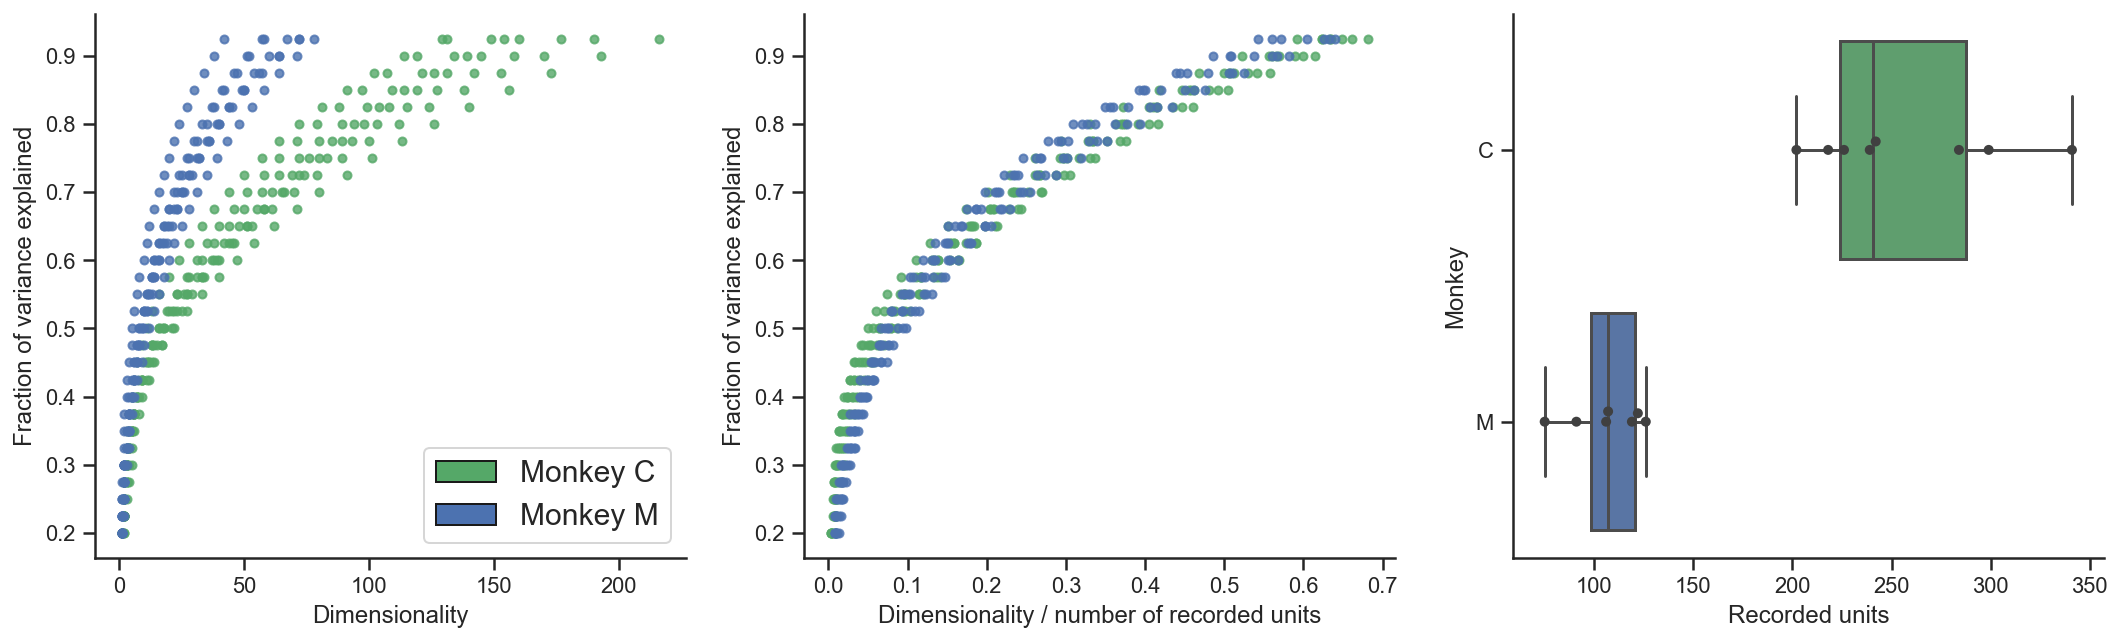

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for i, v in enumerate(evar_to_pcs[:MONKEY_C]): axs[0].plot(v, THRESHOLDS_VARE, '.', c='g', ms=8, alpha=0.8)
for i, v in enumerate(evar_to_pcs[MONKEY_C:]): axs[0].plot(v, THRESHOLDS_VARE, '.', c='b', ms=8, alpha=0.8)
    
for i, v in enumerate(dims_normalized[:MONKEY_C]): axs[1].plot(v, THRESHOLDS_VARE, '.', c='g', ms=8, alpha=0.8)
for i, v in enumerate(dims_normalized[MONKEY_C:]): axs[1].plot(v, THRESHOLDS_VARE, '.', c='b', ms=8, alpha=0.8)
    
axs[0].set_xlabel('Dimensionality')
axs[0].set_ylabel('Fraction of variance explained')

axs[1].set_xlabel('Dimensionality / number of recorded units')
axs[1].set_ylabel('Fraction of variance explained')

legend_elements = [Patch(facecolor='g', edgecolor='k', label='Monkey C'),
                   Patch(facecolor='b', edgecolor='k', label='Monkey M'),]
axs[0].legend(handles=legend_elements, prop={'size': 15}, loc=4)

sns.boxplot(x='Recorded units', y='Monkey', data=df, palette=['g', 'b'])
sns.swarmplot(x='Recorded units', y='Monkey', data=df, color='.25')
    
sns.despine()

In [18]:
''' CHOOSE LEVEL OF VARIANCE EXPLAINED '''
r = 0.4

# Check number of PCs required to explain X % of variance
#K = np.argmax(model_m1pmd.explained_variance_ratio_.cumsum() > exp_var_level)

In [19]:
num_pcs_to_r = []

for s in main_dict.keys():
    
    num_pcs_to_r.append(int(np.argwhere(main_dict[s]['model'].explained_variance_ratio_.cumsum() >= r)[0]) + 1)

### Monkey C

In [20]:
print(np.mean(num_pcs_to_r[:MONKEY_C]))
print(np.std(num_pcs_to_r[:MONKEY_C]))

8.0
1.118033988749895


### Monkey M

In [21]:
print(np.mean(num_pcs_to_r[MONKEY_C:]))
print(np.std(num_pcs_to_r[MONKEY_C:]))

5.714285714285714
0.880630571852711


### 1.2 Participation ratio

In [24]:
PR = []

for s in main_dict.keys():

    lambdas = main_dict[s]['model'].explained_variance_

    D = 0
    for lam in range(len(lambdas)):
        D += lam**2

    PR.append(D / (sum(lambdas)**2) * 100)

In [57]:
print(np.round(PR, 1))

[4.  3.2 5.1 3.5 3.9 4.  3.2 2.6 1.8 2.6 2.  3.7 3.7 1.8 2.7]


In [118]:
np.mean(PR[:MONKEY_C]), np.std(PR[:MONKEY_C])

(3.7016379894487033, 0.702921752667757)

In [119]:
np.mean(PR[MONKEY_C:]), np.std(PR[MONKEY_C:])

(2.6187514770457327, 0.7589119763139425)

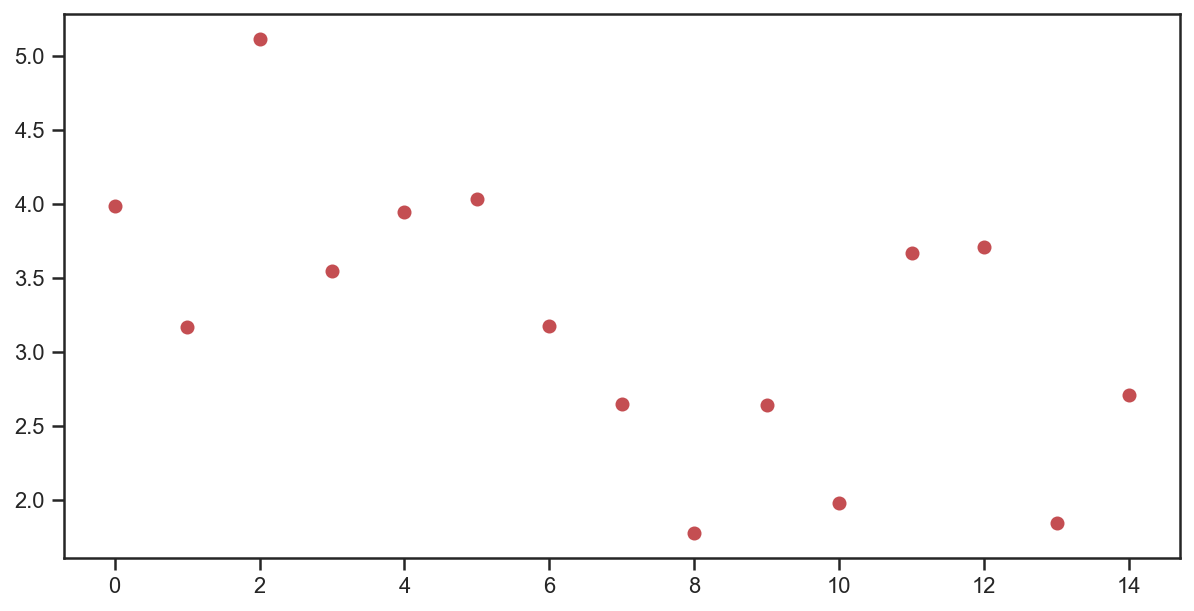

In [27]:
plt.plot(PR, 'ro');

### 1.3 Neural Task Complexity

- Determine upper bound based on experimental task parameters


$\text{NTC} = 4 \frac{T}{\tau} \frac{1}{\Delta}$

> TODO: How to compute the parameters?

In [52]:
''' Specify parameters '''

T = ...
tau = ...
Delta = ...

### Average reach to target in ms $T$

- Each trial began when the monkey moved to the center target.
- After a variable hold period (0.5 – 1.5 s), one of the eight outer targets appeared.
- The monkeys then received an auditory go cue


In [47]:
df = mat2dataframe('/Users/Daphne/Data/Chewie_CO_VR_2016-09-09', shift_idx_fields=True)
df = df.loc[df['epoch'] == 'BL']
df = restrict_to_interval(df, 'idx_target_on', end_point_name='idx_trial_end')

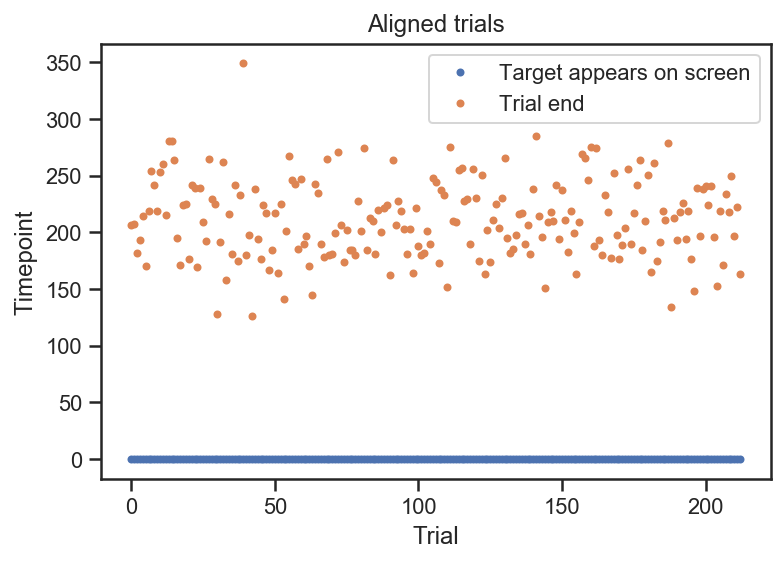

In [54]:
plt.title('Aligned trials')
plt.plot(df['idx_target_on'], '.', label='Target appears on screen')
plt.plot(df['idx_trial_end'], '.', label='Trial end')
plt.xlabel('Trial')
plt.ylabel('Timepoint')
plt.legend();

In [74]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

T_trials = []

for tr in range(len(df)): # For each trial in BL epoch
    # Compute the average reach duration to reach the target in ms
    T_trials.append(df.pos[tr].shape[0])
    
T_mean = np.mean(T_trials)
T_std = np.std(T_trials)

print(f'Average reach duration T : {round(T_mean,2)} ± {round(T_std, 2)} ms')

Average reach duration T : 212.31 ± 34.64 ms


### Temporal autocorrelation $\tau$

In [97]:
#main_dict['2016-09-09']['df'].both_rates[0][0]

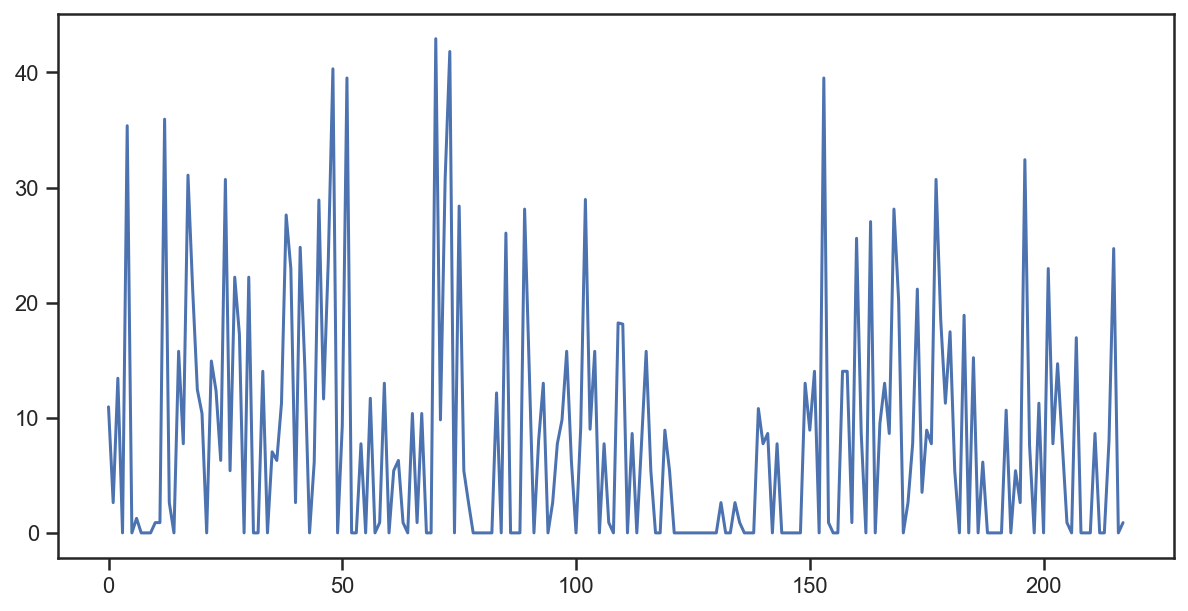

In [100]:
plt.plot(main_dict['2016-09-09']['df'].both_rates[0][0], '-');

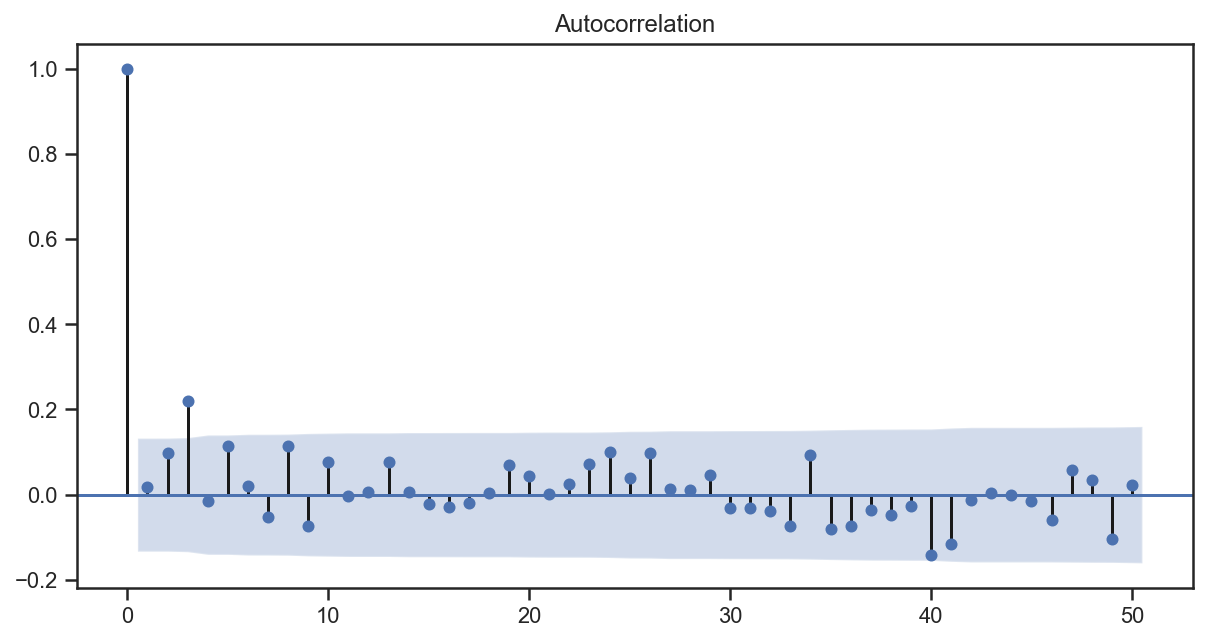

In [96]:
from statsmodels.graphics import tsaplots

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(main_dict['2016-09-09']['df'].both_rates[0][0], lags=50)

### Spatial autocorrelation $\Delta$

- Total angle is $2\pi$
- $\Delta \approx 1.8$ rad

### 1.4 Error and similarity plots

- 

## Trial average the data

- Each trial has a different number of timepoints
- Plus, they are not aligned
- If want to trial-average the data, need to determine a cutoff point
- Problem: N >> T

In [27]:
main_dict[s]['df'].columns

Index(['monkey', 'date', 'task', 'target_direction', 'trial_id', 'result',
       'bin_size', 'perturbation', 'perturbation_info', 'epoch',
       'idx_trial_start', 'idx_target_on', 'idx_go_cue', 'idx_movement_on',
       'idx_peak_speed', 'idx_trial_end', 'pos', 'vel', 'acc', 'force',
       'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide',
       'both_spikes', 'M1_rates', 'PMd_rates', 'both_rates'],
      dtype='object')

In [66]:
s = '2016-09-09'

aligned_td = restrict_to_interval(main_dict[s]['df'], 'idx_go_cue', end_point_name='idx_trial_end')

In [68]:
print("first trial's length in full:", main_dict[s]['df'].both_rates[0].shape)
print("first trial's length in the new dataframe:", aligned_td.both_rates[0].shape)

first trial's length in full: (98, 218)
first trial's length in the new dataframe: (34, 218)


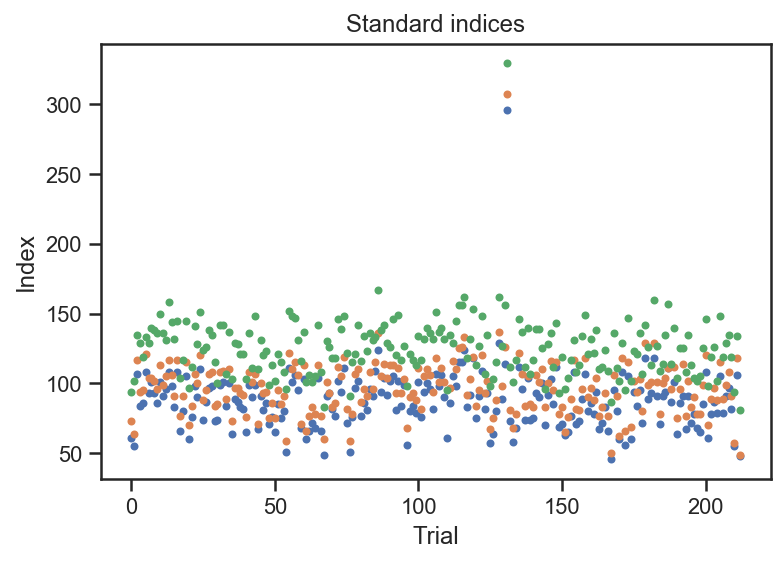

In [69]:
plt.title('Standard indices')
plt.plot(main_dict[s]['df']['idx_go_cue'], '.')
plt.plot(main_dict[s]['df']['idx_movement_on'], '.')
plt.plot(main_dict[s]['df']['idx_trial_end'], '.')
plt.xlabel('Trial')
plt.ylabel('Index');

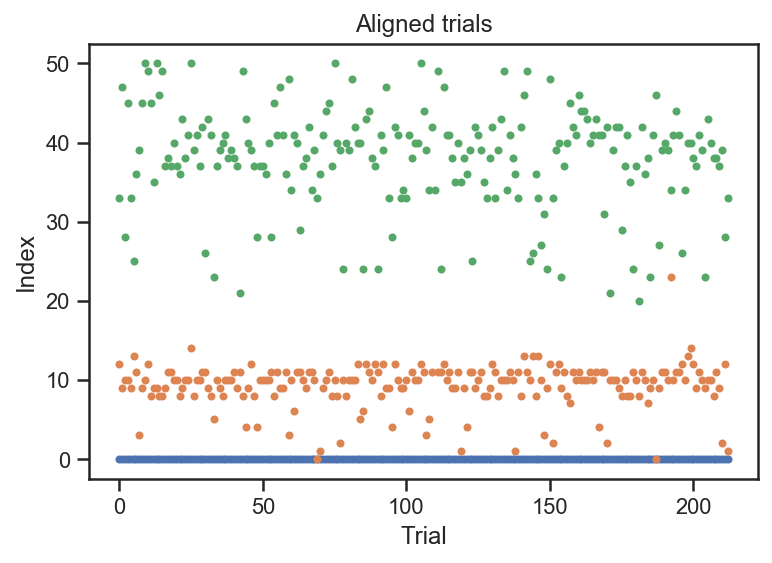

In [70]:
plt.title('Aligned trials')
plt.plot(aligned_td['idx_go_cue'], '.')
plt.plot(aligned_td['idx_movement_on'], '.')
plt.plot(aligned_td['idx_trial_end'], '.')
plt.xlabel('Trial')
plt.ylabel('Index');

In [76]:
N = aligned_td.both_rates[0].shape[1]
T = aligned_td.both_rates[0].shape[0]
P = aligned_td.both_rates.shape[0]

print(N, T, P)

218 34 213


In [77]:
print(P*T)

7242


In [93]:
X_concat = np.concatenate(aligned_td.both_rates.values, axis=0)

In [94]:
X_concat.shape

(8313, 218)

In [96]:
X_concat = X_concat[:2000, :]

X_concat.shape

(2000, 218)

In [97]:
scipy.io.savemat('X_concat_aligned.mat', {'X':X_concat})

In [81]:
# X_tmp = np.zeros((T, N, P))

# for p in range(P):
#     X_tmp[:, :, p] = aligned_td.both_rates[p]

In [28]:
# for i in range(len(aligned_td.both_rates)):
#     print(aligned_td.both_rates[0].shape)

In [31]:
T_cutoffs = [] # Minimum number of timepoints per session

for s in main_dict.keys():
    P = main_dict[s]['df']['both_rates'].shape[0]  
    T_cutoffs.append(min([main_dict[s]['df']['both_rates'][p].shape[0] for p in range(P)]))

In [32]:
''' Get trial averaged data for each session '''

X_tmp = []
X_avg_sessions = []

for i, s in enumerate(main_dict.keys()):
    
    N = main_dict[s]['df']['both_rates'][0].shape[1] # Neurons
    T = main_dict[s]['df']['both_rates'][0].shape[0] # Timepoints
    P = main_dict[s]['df']['both_rates'].shape[0] # Trials

    X_tmp = []
    for p in range(P):
        X_tmp.append(main_dict[s]['df']['both_rates'][p][:T_cutoffs[i], :])
    X_tmp = np.array(X_tmp)
    
    #print(X_tmp.shape)
    
    # Average across trials and store
    X_avg_sessions.append(np.mean(X_tmp, axis=0))

X_avg_sessions = np.array(X_avg_sessions)

In [33]:
X_avg_sessions[3].shape

(89, 242)

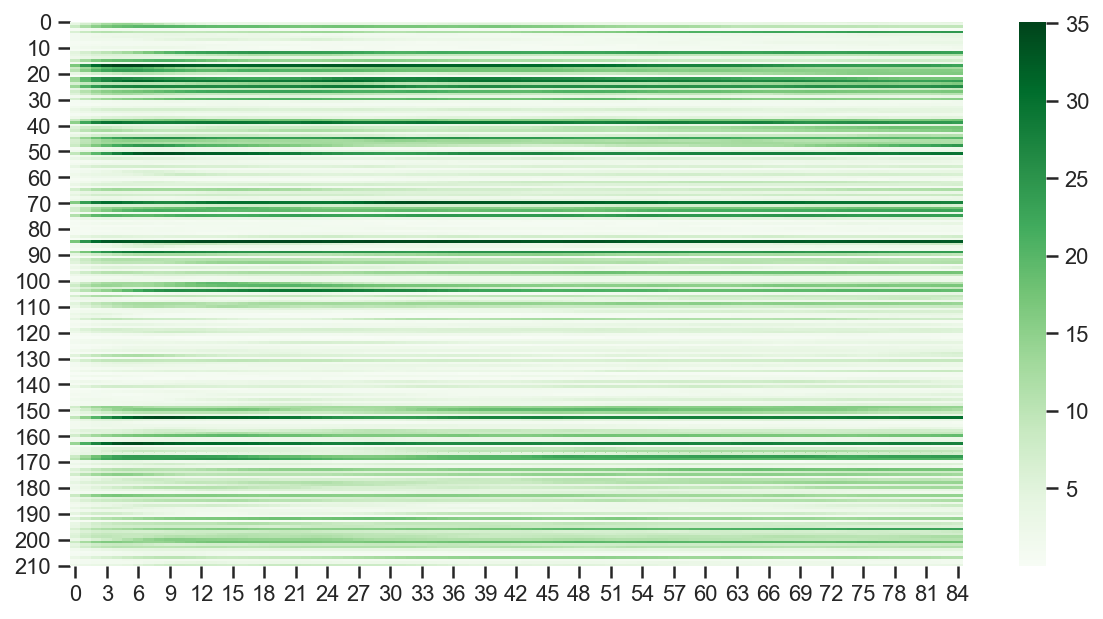

In [35]:
sns.heatmap(X_avg_sessions[0].T, cmap='Greens');

In [36]:
model = PCA()
model.fit(X_avg_sessions[0].T)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [46]:
X = np.array(X_avg_sessions[0])

Cov = X.T @ X

(218, 218)

In [48]:
#np.linalg.eig(Cov)

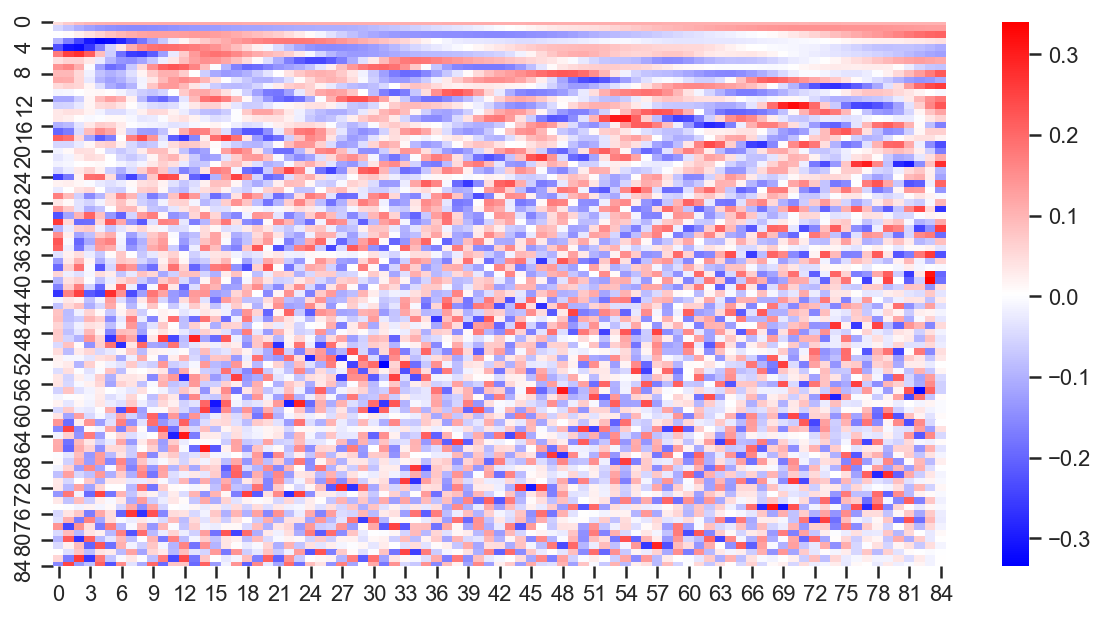

In [41]:
sns.heatmap(model.components_, cmap='bwr');